# Music Genre Classification.
    
    For this problem I use audio data to extract features from the audio and then apply Deep Learnig to predict the different music genres.
    
    I used 2 different dataset for this :
    
    a) Free Music Archive(FMA) and GTZAN dataset.
    
    I extracted different features from the audio signals using the librosa library

In [0]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Downloading the FMA Dataset

FMA Dataset has various sizes of MP3-encoded audio data:

1) fma_small.zip: 8,000 tracks of 30s, 8 balanced genres (GTZAN-like) (7.2 GiB)

2) fma_medium.zip: 25,000 tracks of 30s, 16 unbalanced genres (22 GiB)

3) fma_large.zip: 106,574 tracks of 30s, 161 unbalanced genres (93 GiB)

4) fma_full.zip: 106,574 untrimmed tracks, 161 unbalanced genres (879 GiB)

    For this problem I downloaded the Fma_medium dataset
    
    This dataset can be downloaded from : https://github.com/mdeff/fma

In [0]:
import os
import urllib.request

import sys
import time
import urllib
# Using Progress bar : https://blog.shichao.io/2012/10/04/progress_speed_indicator_for_urlretrieve_in_python.html

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


urllib.request.urlretrieve('https://os.unil.cloud.switch.ch/fma/fma_medium.zip', 'fma_medium.zip',reporthook)

...99%, 22718 MB, 9261 KB/s, 2511 seconds passed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
#DOwnload the metadata file
urllib.request.urlretrieve('https://os.unil.cloud.switch.ch/fma/fma_metadata.zip', 'fma_metadata.zip')

In [ ]:
# uncompress with progress bar https://stackoverflow.com/questions/4006970/monitor-zip-file-extraction-python
import zipfile

zf = zipfile.ZipFile('fma_medium.zip')

uncompress_size = sum((file.file_size for file in zf.infolist()))

extracted_size = 0

for file in zf.infolist():
    extracted_size += file.file_size
    print("%s %%" % (extracted_size * 100/uncompress_size,))
    zf.extract(file)

In [0]:
#Extract Metadata
!unzip fma_metadata.zip

Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  


In [0]:
df = pd.read_csv('fma_metadata/tracks.csv')
df.head(15)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,album.9,album.10,album.11,album.12,artist,artist.1,artist.2,artist.3,artist.4,artist.5,artist.6,artist.7,artist.8,artist.9,artist.10,artist.11,artist.12,artist.13,artist.14,artist.15,artist.16,set,set.1,track,track.1,track.2,track.3,track.4,track.5,track.6,track.7,track.8,track.9,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
0,NaN,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
1,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
6,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,Na

This CSV file is so messy, however I don't need the whole information, I'll store just the top genre and all genre information alone.

In [0]:
xx = df.loc[df['Unnamed: 0'] == '155307']
xx['track.7'].values

array([], dtype=object)

In [0]:
cols = ['folder','filename','genre_top','genres','genre_all']
df_genre = pd.DataFrame(columns= cols)

In [0]:
df_genre

,folder,filename,genre_top,genres,genre_all


     Match genres with the track id's 

In [0]:
folders = []
for i in range(0,156):
  if(i<10):
    folders.append("00"+str(i))
  elif(i>=10 and i<100):
    folders.append("0"+str(i))
  else:
    folders.append(str(i))
  

In [0]:
import os
from tqdm import tqdm
k = 0
for i in tqdm(range(len(folders))):
  for file in os.listdir("fma_medium/"+folders[i]):
    ori_fname = file
    file = int(file.rstrip('.mp3'))
    xx = df.loc[df['Unnamed: 0']==str(file)]
    try:
      ps = xx['track.9'].values[0]
    except:
      ps = np.nan
    try:
      qs = xx['track.7'].values[0]
      
    except:
      qs = np.nan
    try:
      pp = xx['track.8'].values[0]
    except:
      pp = np.nan
    df_genre.loc[k] = [folders[i],ori_fname,qs,pp,ps]
    k+=1

100%|██████████| 156/156 [02:57<00:00,  1.90it/s]


In [0]:
#gen_dict = {}
xx = df.loc[df['Unnamed: 0'] == '672']
xx['track.7'].values

array(['Hip-Hop'], dtype=object)

In [0]:
df_genre.head()

,folder,filename,genre_top,genres,genre_all
0,000,000720.mp3,Rock,[12],[12]
1,000,000764.mp3,Soul-RnB,[11],"[11, 14]"
2,000,000677.mp3,Hip-Hop,[21],[21]
3,000,000619.mp3,Folk,[17],[17]
4,000,000743.mp3,NaN,NaN,NaN


In [0]:
df_genre.to_csv('genre_info_medium.csv',index=False)

In [0]:
df_genre = pd.read_csv('genre_info_medium.csv')

In [0]:
df_genre['genre_top'].value_counts()

Rock                   1596
Electronic              994
Experimental            455
Hip-Hop                 385
Folk                    375
Old-Time / Historic     275
International           226
Pop                     169
Jazz                    151
Classical               118
Country                  98
Instrumental             87
Soul-RnB                 68
Spoken                   45
Blues                    40
Easy Listening            1
Name: genre_top, dtype: int64

 - This is highly imbalanced dataset, So I will remove all those classes with vales counts<80

In [0]:
aa = df_genre[((df_genre['genre_top']!='Easy Listening') & (df_genre['genre_top']!='Blues') & (df_genre['genre_top']!='Spoken')
              & (df_genre['genre_top']!='Soul-RnB'))]

In [0]:
aa['genre_top'].value_counts()

Rock                   1596
Electronic              994
Experimental            455
Hip-Hop                 385
Folk                    375
Old-Time / Historic     275
International           226
Pop                     169
Jazz                    151
Classical               118
Country                  98
Instrumental             87
Name: genre_top, dtype: int64

In [0]:
#Now remove the null values
final_df = aa.dropna(axis=0,subset=['genre_top'])
final_df.shape

(4929, 5)

### Feature extraction Using Librosa

Features that I extracted are :

 Refer : https://librosa.github.io/librosa/feature.html
- > Spectral features

- > Rhythm features


**Spectral Feature 1 : chroma_stft**

Compute a chromagram from a waveform or power spectrogram.

**Spectral Feature 2 : chroma_cqt**

Constant-Q chromagram

**Spectral Feature 3 : chroma_cens**

Computes the chroma variant “Chroma Energy Normalized” (CENS)

**Spectral Feature 4 : melspectrogram**

Compute a mel-scaled spectrogram.

**Spectral Feature 5 : mfcc**

Mel-frequency cepstral coefficients (MFCCs)

**Spectral Feature 6 : rms**

Compute root-mean-square (RMS) value for each frame, either from the audio samples y or from a spectrogram S.

**Spectral Feature 7 : spectral_centroid**

Compute the spectral centroid.

**Spectral Feature 8 : spectral_bandwidth**

Compute p’th-order spectral bandwidth.

**Spectral Feature 9 : spectral_contrast**

Compute spectral contrast

**Spectral Feature 10 : spectral_flatness**

Compute spectral flatness

**Spectral Feature 11 : spectral_rolloff**

Compute roll-off frequency.

**Spectral Feature 12 : poly_features**

Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram.

**Spectral Feature 13 : tonnetz**

Computes the tonal centroid features (tonnetz)

**Spectral Feature 14 : zero_crossing_rate**

Compute the zero-crossing rate of an audio time series.

    All These Spectral Features make upto 205 dimensions
    
**Rhythm Feature 15 : tempogram**

Compute the tempogram: local autocorrelation of the onset strength envelope.

    This is of 384 dimensions







In [0]:
folder = []
aa = final_df['folder'].values
for i in range(len(aa)):
  if(aa[i]<10):
    folder.append("00"+str(aa[i]))
  elif(aa[i]>=10 and aa[i]<100):
    folder.append("0"+str(aa[i]))
  else:
    folder.append(str(aa[i]))

In [0]:
len(folder)

4929

In [0]:
cols = []
for i in range(12):
  cols.append('ch_stft'+str(i))

for i in range(12):
  cols.append('ch_cqt'+str(i))

for i in range(12):
  cols.append('ch_cens'+str(i))
  
for i in range(128):
  cols.append('ch_mel'+str(i))

for i in range(20):
  cols.append('ch_mfcc'+str(i))

cols.append('ch_rms')
cols.append('ch_speccent')
cols.append('ch_bw')

for i in range(7):
  cols.append('ch_cr'+str(i))

cols.append('ch_flat')
cols.append('ch_roll')
cols.append('ch_poly0')
cols.append('ch_poly1')

for i in range(6):
  cols.append('ch_torr'+str(i))

cols.append('ch_zero')

for i in range(384):
  cols.append('tempo'+str(i))


In [ ]:
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

#ch_stft  #chroma_stft
#ch_cqt   #chroma_cqt
#ch_cens   #chroma_cens
#ch_mel   #mel-scaled spectrogram.
#ch_mfcc   #Mel-frequency cepstral coefficients 
#ch_rms    #RMS
#ch_speccent  #spectral centroid.
#ch_bw  #spectral bandwidth
#ch_cr  #Spectral Contrast
#ch_flat  #spectral flatness
#ch_roll  #Spectral Rolloff
#ch_poly  #polynomial features
#ch_torr  #Tonal Centroid features
#ch_zero  #Zero crossing rate

####### Rhythm Features ######
#tempo = tempogram

#cols = ['ch_stft','ch_cqt','ch_cens','ch_mel','ch_mfcc','ch_rms','ch_spec','ch_bw','ch_cr','ch_flat','ch_roll','ch_poly','ch_torr','ch_zero','tempo']
missed = []
filenames = final_df['filename'].values
for i in tqdm(range(len(filenames))):
  if(i>234):
    try:
      y, sr = librosa.load('fma_medium/'+str(folder[i])+'/'+str(filenames[i]), duration=30)
      ch_stft = np.mean(librosa.feature.chroma_stft(y,sr).T,axis=0)
      ch_cqt = np.mean(librosa.feature.chroma_cqt(y,sr).T,axis=0)
      ch_cens = np.mean(librosa.feature.chroma_cens(y,sr).T,axis=0)
      ch_mel = np.mean(librosa.feature.melspectrogram(y,sr).T,axis=0)
      ch_mfcc = np.mean(librosa.feature.mfcc(y,sr).T,axis=0)
      ch_rms = np.mean(librosa.feature.rms(y).T,axis=0)
      ch_speccent = np.mean(librosa.feature.spectral_centroid(y,sr).T,axis=0)
      ch_bw = np.mean(librosa.feature.spectral_bandwidth(y,sr).T,axis=0)
      ch_cr = np.mean(librosa.feature.spectral_contrast(y,sr).T,axis=0)
      ch_flat = np.mean(librosa.feature.spectral_flatness(y).T,axis=0)
      ch_roll = np.mean(librosa.feature.spectral_rolloff(y,sr).T,axis=0)
      ch_poly = np.mean(librosa.feature.poly_features(y,sr).T,axis=0)
      ch_torr = np.mean(librosa.feature.tonnetz(y,sr).T,axis=0)
      ch_zero = np.mean(librosa.feature.zero_crossing_rate(y,sr).T,axis=0)
  
  #Rhythm Features
  
      tempo = np.mean(librosa.feature.tempogram(y,sr).T,axis=0)
  
      cc = np.hstack((ch_stft,ch_cqt,ch_cens,ch_mel,ch_mfcc,ch_rms,ch_speccent,ch_bw,ch_cr,ch_flat,ch_roll,ch_poly,ch_torr,ch_zero,tempo))
  
      dff = pd.DataFrame(columns=cols,data=cc.reshape(1,-1))
      dff.to_csv('/content/drive/My Drive/librosa_feat/'+filenames[i]+'.csv',index=True)
    except:
      missed.append(filenames[i])

  The above code takes approx 7 hours to run 

In [0]:
df_genre.head()

,folder,filename,genre_top,genres,genre_all
0,0,000720.mp3,Rock,[12],[12]
1,0,000764.mp3,Soul-RnB,[11],"[11, 14]"
2,0,000677.mp3,Hip-Hop,[21],[21]
3,0,000619.mp3,Folk,[17],[17]
4,0,000743.mp3,NaN,NaN,NaN


In [0]:
xx= df_genre['filename'].values
xx

array(['000720.mp3', '000764.mp3', '000677.mp3', ..., '155130.mp3',
       '155298.mp3', '155289.mp3'], dtype=object)

In [0]:
librosa_feat = pd.DataFrame(columns = cols)

In [0]:
import os
k = 0
genre = []
fname = []
for file in os.listdir("/content/drive/My Drive/librosa_feat/"):
  f_name = file.rstrip('.csv')
  genre_top = df_genre[df_genre['filename']==f_name]['genre_top'].values[0]
  dff = pd.read_csv("/content/drive/My Drive/librosa_feat/"+file)
  dff.drop('Unnamed: 0',inplace=True,axis=1)
  librosa_feat.loc[k] = dff.loc[0]
  fname.append(f_name)
  genre.append(genre_top)
  k+=1

In [0]:
dff1 = librosa_feat
dff1['filename'] = fname
dff1['genre_top'] = genre
dff1.head()

,ch_stft0,ch_stft1,ch_stft2,ch_stft3,ch_stft4,ch_stft5,ch_stft6,ch_stft7,ch_stft8,ch_stft9,ch_stft10,ch_stft11,ch_cqt0,ch_cqt1,ch_cqt2,ch_cqt3,ch_cqt4,ch_cqt5,ch_cqt6,ch_cqt7,ch_cqt8,ch_cqt9,ch_cqt10,ch_cqt11,ch_cens0,ch_cens1,ch_cens2,ch_cens3,ch_cens4,ch_cens5,ch_cens6,ch_cens7,ch_cens8,ch_cens9,ch_cens10,ch_cens11,ch_mel0,ch_mel1,ch_mel2,ch_mel3,...,tempo346,tempo347,tempo348,tempo349,tempo350,tempo351,tempo352,tempo353,tempo354,tempo355,tempo356,tempo357,tempo358,tempo359,tempo360,tempo361,tempo362,tempo363,tempo364,tempo365,tempo366,tempo367,tempo368,tempo369,tempo370,tempo371,tempo372,tempo373,tempo374,tempo375,tempo376,tempo377,tempo378,tempo379,tempo380,tempo381,tempo382,tempo383,filename,genre_top
0,0.870915,0.469555,0.338753,0.283835,0.348242,0.306773,0.320543,0.437052,0.310676,0.337913,0.433510,0.563965,0.905096,0.731667,0.677565,0.616995,0.554893,0.561668,0.577598,0.592295,0.576777,0.593128,0.600037,0.744982,0.422565,0.337826,0.295740,0.264999,0.223352,0.225730,0.240517,0.248468,0.240928,0.255931,0.254233,0.354186,16.968292,13.607184,22.851642,24.261958,...,0.000036,0.000033,0.000027,0.000028,0.000035,0.000027,0.000016,0.000013,0.000011,0.000009,0.000010,0.000011,0.000008,0.000004,0.000004,0.000003,0.000002,0.000002,2.581738e-06,1.500618e-06,8.729207e-07,6.702506e-07,4.809821e-07,3.404987e-07,3.314668e-07,2.884787e-07,1.401791e-07,7.390441e-08,4.735238e-08,2.700251e-08,1.525953e-08,1.122437e-08,6.083282e-09,1.689642e-09,4.562048e-10,1.094808e-10,1.323903e-11,3.319180e-16,024141.mp3,Electronic
1,0.387601,0.413641,0.476364,0.399939,0.384493,0.448016,0.451451,0.610694,0.497455,0.412965,0.332142,0.341824,0.565694,0.536533,0.566651,0.533164,0.576046,0.611796,0.659547,0.770350,0.627023,0.503032,0.491866,0.544966,0.255770,0.250013,0.270957,0.251967,0.263457,0.286616,0.343969,0.386884,0.330496,0.221671,0.217635,0.249605,0.347560,4.955163,19.792448,34.929881,...,0.000040,0.000037,0.000034,0.000030,0.000024,0.000018,0.000015,0.000013,0.000012,0.000010,0.000008,0.000007,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,1.477004e-06,1.187231e-06,9.210136e-07,6.961799e-07,5.151107e-07,3.703928e-07,2.633548e-07,1.877687e-07,1.288761e-07,8.516912e-08,5.342177e-08,3.000814e-08,1.550887e-08,7.739616e-09,3.643620e-09,1.496772e-09,5.039122e-10,1.162205e-10,1.392086e-11,6.472253e-16,024369.mp3,International
2,0.315728,0.296270,0.342887,0.409035,0.406500,0.441813,0.440067,0.445473,0.351242,0.362294,0.415011,0.365663,0.512527,0.508491,0.542535,0.626240,0.566063,0.571958,0.569116,0.515327,0.474925,0.532485,0.599292,0.500775,0.249220,0.251077,0.274776,0.318009,0.305756,0.302523,0.304644,0.260011,0.229949,0.268160,0.309166,0.244051,16.937040,89.238786,213.053298,195.002048,...,0.000024,0.000023,0.000020,0.000013,0.000011,0.000012,0.000012,0.000011,0.000007,0.000005,0.000005,0.000006,0.000004,0.000003,0.000002,0.000002,0.000002,0.000001,8.106562e-07,5.888577e-07,5.397553e-07,6.825298e-07,4.810567e-07,2.272828e-07,1.325971e-07,9.496149e-08,7.897431e-08,4.950137e-08,2.513751e-08,1.290788e-08,7.584607e-09,5.332332e-09,3.018657e-09,1.004855e-09,2.380581e-10,5.866812e-11,9.360488e-12,1.748011e-16,024946.mp3,Experimental
3,0.479099,0.427292,0.367863,0.304129,0.298696,0.244488,0.388888,0.330673,0.366357,0.471034,0.452465,0.568701,0.701335,0.536027,0.476183,0.403019,0.367072,0.438667,0.467162,0.489202,0.595637,0.559321,0.534327,0.758218,0.403317,0.269033,0.221777,0.183479,0.143707,0.185038,0.222437,0.243737,0.290547,0.276349,0.297569,0.406373,52.312733,493.222357,365.015606,207.679979,...,0.000038,0.000028,0.000026,0.000031,0.000028,0.000020,0.000014,0.000012,0.000013,0.000011,0.000008,0.000006,0.000005,0.000006,0.000005,0.000003,0.000002,0.000002,1.759585e-06,1.284753e-06,8.059828e-07,5.579577e-07,5.072810e-07,4.369845e-07,2.807414e-07,1.561494e-07,9.847832e-08,7.978431e-08,5.605515e-08,2.936731e-08,1.353056e-08,6.890368e-09,4.163570e-09,1.848533e-09,5.038154e-10,9.528054e-11,1.206745e-11,8.810584e-16,024065.mp3,Electronic
4,0.292667,0.676953,

In [0]:
#Write the file to csv
dff1.to_csv('librosa_features.csv',index=False)

In [0]:
librosa_feat = pd.read_csv('librosa_features.csv')

In [0]:
#Now That we have the librosa features, Let's build the Machine Learning Model
librosa_feat['genre_top'].value_counts()

Rock                   1594
Electronic              992
Experimental            454
Hip-Hop                 385
Folk                    375
Old-Time / Historic     275
International           226
Pop                     169
Jazz                    151
Classical               118
Country                  98
Instrumental             87
Name: genre_top, dtype: int64

    I will consider only top 9 labels and eliminate Country and Instrumental.

In [0]:
aa = librosa_feat[(librosa_feat['genre_top']!='Country') & (librosa_feat['genre_top']!='Instrumental') & (librosa_feat['genre_top']!='Classical')]
aa['genre_top'].value_counts()

Rock                   1594
Electronic              992
Experimental            454
Hip-Hop                 385
Folk                    375
Old-Time / Historic     275
International           226
Pop                     169
Jazz                    151
Name: genre_top, dtype: int64

**Encoding Labels**

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(np.array(aa['genre_top'].values).reshape(-1, 1))
enc.get_feature_names()

array(['x0_Electronic', 'x0_Experimental', 'x0_Folk', 'x0_Hip-Hop',
       'x0_International', 'x0_Jazz', 'x0_Old-Time / Historic', 'x0_Pop',
       'x0_Rock'], dtype=object)

**Scale the features**

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(aa.iloc[:,:-2]))

**Train-Test-Split**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Build A simple Neural Network**

In [0]:
from keras import models
from keras import layers
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
model = models.Sequential()

model.add(layers.Dense(4096, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_normal'))
model.add(Dropout(0.5))

model.add(layers.Dense(2048, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))

model.add(layers.Dense(1024, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))

model.add(layers.Dense(512, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.5))

model.add(layers.Dense(256, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(layers.Dense(128, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(layers.Dense(64, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))

model.add(layers.Dense(32, activation='relu',kernel_initializer='he_normal'))
model.add(Dropout(0.25))


model.add(layers.Dense(9, activation='softmax'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 4096)              2416640   
_________________________________________________________________
dropout_71 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 2048)              8390656   
_________________________________________________________________
dropout_72 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_127 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dropout_73 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_128 (Dense)            (None, 512)             

In [0]:
import keras
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=100, mode='max', baseline=None, restore_best_weights=True)


In [0]:
history = model.fit(X_train,y_train,epochs=1000,batch_size=128,validation_data=(X_test,y_test),callbacks=[es])

Train on 3696 samples, validate on 925 samples
Epoch 1/1000
3696/3696 [==============================] - 4s 1ms/step - loss: 5.4948 - acc: 0.1534 - val_loss: 2.1643 - val_acc: 0.1254
Epoch 2/1000
3696/3696 [==============================] - 0s 134us/step - loss: 2.5340 - acc: 0.1810 - val_loss: 2.1302 - val_acc: 0.3427
Epoch 3/1000
3696/3696 [==============================] - 1s 136us/step - loss: 2.1732 - acc: 0.2267 - val_loss: 2.0555 - val_acc: 0.3265
Epoch 4/1000
3696/3696 [==============================] - 0s 134us/step - loss: 2.1148 - acc: 0.2738 - val_loss: 2.0292 - val_acc: 0.3557
Epoch 5/1000
3696/3696 [==============================] - 0s 132us/step - loss: 2.0570 - acc: 0.2819 - val_loss: 2.0235 - val_acc: 0.4011
Epoch 6/1000
3696/3696 [==============================] - 0s 133us/step - loss: 2.0296 - acc: 0.2927 - val_loss: 1.9769 - val_acc: 0.3557
Epoch 7/1000
3696/3696 [==============================] - 0s 134us/step - loss: 1.9918 - acc: 0.3109 - val_loss: 1.9511 - val_a

In [0]:
model.evaluate(X_test,y_test,batch_size=64)

925/925 [==============================] - 0s 61us/step


[1.7325226371352738, 0.5189189193377624]

**Now this gives poor results, So let's balance the train dataset using SMOTE algorithm**

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)
X_train_new, y_train_new = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
history = model.fit(X_train_new,y_train_new,epochs=100,batch_size=64,validation_data=(X_test,y_test),callbacks=[es])

Train on 11403 samples, validate on 925 samples
Epoch 1/100
11403/11403 [==============================] - 4s 378us/step - loss: 2.7874 - acc: 0.1201 - val_loss: 2.1961 - val_acc: 0.0832
Epoch 2/100
11403/11403 [==============================] - 1s 127us/step - loss: 2.2229 - acc: 0.1335 - val_loss: 2.2085 - val_acc: 0.0703
Epoch 3/100
11403/11403 [==============================] - 1s 126us/step - loss: 2.0991 - acc: 0.1879 - val_loss: 2.0719 - val_acc: 0.2227
Epoch 4/100
11403/11403 [==============================] - 1s 126us/step - loss: 1.9562 - acc: 0.2325 - val_loss: 1.9339 - val_acc: 0.2346
Epoch 5/100
11403/11403 [==============================] - 1s 130us/step - loss: 1.9095 - acc: 0.2598 - val_loss: 1.9062 - val_acc: 0.2303
Epoch 6/100
11403/11403 [==============================] - 1s 129us/step - loss: 1.8762 - acc: 0.2705 - val_loss: 1.9099 - val_acc: 0.2205
Epoch 7/100
11403/11403 [==============================] - 2s 132us/step - loss: 1.8447 - acc: 0.2798 - val_loss: 1.96

In [0]:
model.evaluate(X_test,y_test,batch_size=64)

925/925 [==============================] - 0s 45us/step


[2.2292584715662778, 0.46486486470377125]

 It's even bad after balancing

**Using Convnet**

In [0]:
x_train_conv = np.expand_dims(X_train, axis = -1)
x_test_conv = np.expand_dims(X_test, axis = -1)

In [0]:
x_train_conv.shape

(3696, 589, 1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D,MaxPooling1D


model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu',input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

model.add(Dense(9, activation='softmax'))
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 588, 128)          384       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 587, 64)           16448     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 586, 32)           4128      
_________________________________________________________________
dropout_88 (Dropout)         (None, 586, 32)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 293, 32)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 9376)              0         
_________________________________________________________________
dense_147 (Dense)            (None, 256)             

In [0]:
import keras
model.compile(optimizer='sgd',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=100, mode='max', baseline=None, restore_best_weights=True)


In [0]:
history = model.fit(x_train_conv,y_train,epochs=1000,batch_size=128,validation_data=(x_test_conv,y_test),callbacks=[es])

Train on 3696 samples, validate on 925 samples
Epoch 1/1000
3696/3696 [==============================] - 4s 1ms/step - loss: 2.0442 - acc: 0.2863 - val_loss: 1.9136 - val_acc: 0.3535
Epoch 2/1000
3696/3696 [==============================] - 0s 131us/step - loss: 1.8889 - acc: 0.3731 - val_loss: 1.8378 - val_acc: 0.3903
Epoch 3/1000
3696/3696 [==============================] - 0s 133us/step - loss: 1.8643 - acc: 0.3728 - val_loss: 1.8190 - val_acc: 0.4076
Epoch 4/1000
3696/3696 [==============================] - 0s 130us/step - loss: 1.8168 - acc: 0.3877 - val_loss: 1.7843 - val_acc: 0.4108
Epoch 5/1000
3696/3696 [==============================] - 0s 131us/step - loss: 1.7876 - acc: 0.3942 - val_loss: 1.7779 - val_acc: 0.4130
Epoch 6/1000
3696/3696 [==============================] - 1s 136us/step - loss: 1.7611 - acc: 0.3961 - val_loss: 1.7408 - val_acc: 0.4216
Epoch 7/1000
3696/3696 [==============================] - 0s 135us/step - loss: 1.7426 - acc: 0.4115 - val_loss: 1.7083 - val_a

In [0]:
model.evaluate(x_test_conv,y_test,batch_size=64)

925/925 [==============================] - 0s 102us/step


[1.4958930417653677, 0.5545945951100942]

**Conv1d along with One-directional LSTM**

In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

model = Sequential()

model.add(LSTM(units=256, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))

model.add(layers.Dense(9, activation='softmax'))
model.summary()



Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 589, 256)          264192    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 588, 64)           32832     
_________________________________________________________________
lstm_21 (LSTM)               (None, 588, 128)          98816     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 587, 32)           8224      
_________________________________________________________________
lstm_22 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_156 (Dense)            (None, 9)                 585       
Total params: 429,481
Trainable params: 429,481
Non-trainable params: 0
_______________________________________________

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=10, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train_conv,y_train,epochs=100,batch_size=256,validation_data=(x_test_conv,y_test),callbacks=[es])

Train on 3696 samples, validate on 925 samples
Epoch 1/100
3696/3696 [==============================] - 53s 14ms/step - loss: 1.9868 - acc: 0.3417 - val_loss: 1.8120 - val_acc: 0.3535
Epoch 2/100
3696/3696 [==============================] - 46s 13ms/step - loss: 1.8535 - acc: 0.3666 - val_loss: 1.7939 - val_acc: 0.3849
Epoch 3/100
3696/3696 [==============================] - 47s 13ms/step - loss: 1.8469 - acc: 0.3615 - val_loss: 1.7945 - val_acc: 0.3881
Epoch 4/100
3696/3696 [==============================] - 46s 13ms/step - loss: 1.8365 - acc: 0.3753 - val_loss: 1.7884 - val_acc: 0.3957
Epoch 5/100
3696/3696 [==============================] - 47s 13ms/step - loss: 1.8352 - acc: 0.3782 - val_loss: 1.7863 - val_acc: 0.3946
Epoch 6/100
3696/3696 [==============================] - 46s 12ms/step - loss: 1.8327 - acc: 0.3799 - val_loss: 1.7839 - val_acc: 0.3946
Epoch 7/100
3696/3696 [==============================] - 46s 12ms/step - loss: 1.8276 - acc: 0.3785 - val_loss: 1.7817 - val_acc: 0

In [0]:
model.evaluate(x_test_conv,y_test,batch_size=64)

925/925 [==============================] - 15s 16ms/step


[1.781652520927223, 0.4032432430821496]

**Using one-Directional LSTM**

In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

model = Sequential()

model.add(LSTM(units=256, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))

model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))

model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))


model.add(layers.Dense(9, activation='softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 589, 256)          264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 589, 128)          197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 585       
Total params: 511,305
Trainable params: 511,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=10, mode='max', baseline=None, restore_best_weights=True)


In [0]:
history = model.fit(x_train_conv,y_train,epochs=100,batch_size=128,validation_data=(x_test_conv,y_test),callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3696 samples, validate on 925 samples
Epoch 1/100
3696/3696 [==============================] - 104s 28ms/step - loss: 1.9695 - acc: 0.3379 - val_loss: 1.8517 - val_acc: 0.3481
Epoch 2/100
3696/3696 [==============================] - 97s 26ms/step - loss: 1.8776 - acc: 0.3439 - val_loss: 1.8070 - val_acc: 0.3914
Epoch 3/100
3696/3696 [==============================] - 96s 26ms/step - loss: 1.8417 - acc: 0.3531 - val_loss: 1.7772 - val_acc: 0.3773
Epoch 4/100
3696/3696 [==============================] - 96s 26ms/step - loss: 1.7921 - acc: 0.3620 - val_loss: 1.7413 - val_acc: 0.3914
Epoch 5/100
3696/3696 [==============================] - 96s 26ms/step - loss: 1.7800 - acc: 0.3793 - val_loss: 1.7619 - val_acc: 0.3989
Epoch 6/100
3696/3696 [==============================] - 95s 26ms/step - loss: 1.8041 - acc: 0.3674 - val_loss: 1.7908 - val_acc: 0.3935
Epoch 7/100
3696/3696 [=============

In [0]:
model.evaluate(x_test_conv,y_test,batch_size=64)

925/925 [==============================] - 16s 17ms/step


[1.8114253930787783, 0.4032432433076807]

**Try the same thing on GTZAN Dataset**



The dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres namely, blues, classical, country, disco, hiphop, jazz, reggae, rock, metal and pop. Each genre consists of 100 sound clips.

This is more of a Balanced Dataset.


In [0]:
import os
import urllib.request

import sys
import time
import urllib
# Using Progress bar : https://blog.shichao.io/2012/10/04/progress_speed_indicator_for_urlretrieve_in_python.html

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


urllib.request.urlretrieve('http://opihi.cs.uvic.ca/sound/genres.tar.gz', 'genres.tar.gz',reporthook)

...100%, 1168 MB, 805 KB/s, 1485 seconds passed

('genres.tar.gz', <http.client.HTTPMessage at 0x7f467389a4e0>)

In [0]:
import tarfile
tf = tarfile.open("genres.tar.gz")
tf.extractall()

In [0]:
cols = []
cols.append('filename')
for i in range(12):
  cols.append('ch_stft'+str(i))

for i in range(12):
  cols.append('ch_cqt'+str(i))

for i in range(12):
  cols.append('ch_cens'+str(i))
  
for i in range(128):
  cols.append('ch_mel'+str(i))

for i in range(20):
  cols.append('ch_mfcc'+str(i))

cols.append('ch_rms')
cols.append('ch_speccent')
cols.append('ch_bw')

for i in range(7):
  cols.append('ch_cr'+str(i))

cols.append('ch_flat')
cols.append('ch_roll')
cols.append('ch_poly0')
cols.append('ch_poly1')

for i in range(6):
  cols.append('ch_torr'+str(i))

cols.append('ch_zero')

for i in range(384):
  cols.append('tempo'+str(i))

cols.append('label')

In [0]:
dff = pd.DataFrame(columns=cols)
dff

,filename,ch_stft0,ch_stft1,ch_stft2,ch_stft3,ch_stft4,ch_stft5,ch_stft6,ch_stft7,ch_stft8,ch_stft9,ch_stft10,ch_stft11,ch_cqt0,ch_cqt1,ch_cqt2,ch_cqt3,ch_cqt4,ch_cqt5,ch_cqt6,ch_cqt7,ch_cqt8,ch_cqt9,ch_cqt10,ch_cqt11,ch_cens0,ch_cens1,ch_cens2,ch_cens3,ch_cens4,ch_cens5,ch_cens6,ch_cens7,ch_cens8,ch_cens9,ch_cens10,ch_cens11,ch_mel0,ch_mel1,ch_mel2,...,tempo345,tempo346,tempo347,tempo348,tempo349,tempo350,tempo351,tempo352,tempo353,tempo354,tempo355,tempo356,tempo357,tempo358,tempo359,tempo360,tempo361,tempo362,tempo363,tempo364,tempo365,tempo366,tempo367,tempo368,tempo369,tempo370,tempo371,tempo372,tempo373,tempo374,tempo375,tempo376,tempo377,tempo378,tempo379,tempo380,tempo381,tempo382,tempo383,label


    For this also I extracted the same features as above

In [0]:
#from tqdm import tqdm_notebook as tqdm

#ch_stft  #chroma_stft
#ch_cqt   #chroma_cqt
#ch_cens   #chroma_cens
#ch_mel   #mel-scaled spectrogram.
#ch_mfcc   #Mel-frequency cepstral coefficients 
#ch_rms    #RMS
#ch_speccent  #spectral centroid.
#ch_bw  #spectral bandwidth
#ch_cr  #Spectral Contrast
#ch_flat  #spectral flatness
#ch_roll  #Spectral Rolloff
#ch_poly  #polynomial features
#ch_torr  #Tonal Centroid features
#ch_zero  #Zero crossing rate

####### Rhythm Features ######
#tempo = tempogram



from tqdm import tqdm
k = 0
labels = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
for i in tqdm(range(len(labels))):
  file = os.listdir("genres/"+labels[i])
  for j in file:
    y, sr = librosa.load('genres/'+labels[i]+'/'+j,duration=30,mono=True)
    ch_stft = np.mean(librosa.feature.chroma_stft(y,sr).T,axis=0)
    ch_cqt = np.mean(librosa.feature.chroma_cqt(y,sr).T,axis=0)
    ch_cens = np.mean(librosa.feature.chroma_cens(y,sr).T,axis=0)
    ch_mel = np.mean(librosa.feature.melspectrogram(y,sr).T,axis=0)
    ch_mfcc = np.mean(librosa.feature.mfcc(y,sr).T,axis=0)
    ch_rms = np.mean(librosa.feature.rms(y).T,axis=0)
    ch_speccent = np.mean(librosa.feature.spectral_centroid(y,sr).T,axis=0)
    ch_bw = np.mean(librosa.feature.spectral_bandwidth(y,sr).T,axis=0)
    ch_cr = np.mean(librosa.feature.spectral_contrast(y,sr).T,axis=0)
    ch_flat = np.mean(librosa.feature.spectral_flatness(y).T,axis=0)
    ch_roll = np.mean(librosa.feature.spectral_rolloff(y,sr).T,axis=0)
    ch_poly = np.mean(librosa.feature.poly_features(y,sr).T,axis=0)
    ch_torr = np.mean(librosa.feature.tonnetz(y,sr).T,axis=0)
    ch_zero = np.mean(librosa.feature.zero_crossing_rate(y,sr).T,axis=0)
  
  #Rhythm Features
  
    tempo = np.mean(librosa.feature.tempogram(y,sr).T,axis=0)
  
    cc = np.hstack((j,ch_stft,ch_cqt,ch_cens,ch_mel,ch_mfcc,ch_rms,ch_speccent,ch_bw,ch_cr,ch_flat,ch_roll,ch_poly,ch_torr,ch_zero,tempo,labels[i]))
    dff.loc[k] = cc
    k+=1

100%|██████████| 10/10 [1:20:05<00:00, 477.67s/it]


In [0]:
dff.to_csv('gtzan_feat.csv',index=False)

In [0]:
dff = pd.read_csv('gtzan_feat.csv')

In [0]:
dff.head(5)

,filename,ch_stft0,ch_stft1,ch_stft2,ch_stft3,ch_stft4,ch_stft5,ch_stft6,ch_stft7,ch_stft8,ch_stft9,ch_stft10,ch_stft11,ch_cqt0,ch_cqt1,ch_cqt2,ch_cqt3,ch_cqt4,ch_cqt5,ch_cqt6,ch_cqt7,ch_cqt8,ch_cqt9,ch_cqt10,ch_cqt11,ch_cens0,ch_cens1,ch_cens2,ch_cens3,ch_cens4,ch_cens5,ch_cens6,ch_cens7,ch_cens8,ch_cens9,ch_cens10,ch_cens11,ch_mel0,ch_mel1,ch_mel2,...,tempo345,tempo346,tempo347,tempo348,tempo349,tempo350,tempo351,tempo352,tempo353,tempo354,tempo355,tempo356,tempo357,tempo358,tempo359,tempo360,tempo361,tempo362,tempo363,tempo364,tempo365,tempo366,tempo367,tempo368,tempo369,tempo370,tempo371,tempo372,tempo373,tempo374,tempo375,tempo376,tempo377,tempo378,tempo379,tempo380,tempo381,tempo382,tempo383,label
0,blues.00040.au,0.375965,0.451368,0.355736,0.438277,0.290174,0.283985,0.326355,0.489801,0.670385,0.457442,0.336223,0.296987,0.516121,0.575849,0.559530,0.621552,0.594918,0.572508,0.567386,0.686920,0.761443,0.625115,0.521066,0.488931,0.222007,0.268827,0.272950,0.298432,0.286963,0.263243,0.259575,0.346527,0.378365,0.304453,0.220373,0.209066,6.828683,37.742010,44.561427,...,0.000052,0.000034,0.000021,0.000014,0.000013,0.000014,0.000018,0.000019,0.000014,0.000009,0.000005,0.000004,0.000004,0.000004,0.000006,0.000005,0.000003,0.000001,9.653015e-07,7.806235e-07,7.770270e-07,8.633489e-07,7.983250e-07,5.139085e-07,2.663995e-07,1.391679e-07,8.559668e-08,6.492570e-08,6.012982e-08,5.494311e-08,3.423466e-08,1.406182e-08,4.833467e-09,1.771949e-09,7.388978e-10,3.137843e-10,1.101092e-10,1.731139e-11,9.288669e-16,blues
1,blues.00041.au,0.324293,0.358936,0.419548,0.567029,0.303828,0.251769,0.324718,0.393955,0.453599,0.427112,0.491355,0.327263,0.412578,0.431178,0.530905,0.649242,0.519717,0.410141,0.424176,0.505669,0.536502,0.555833,0.584349,0.476978,0.187662,0.202343,0.297380,0.371538,0.293206,0.206733,0.199042,0.265278,0.289482,0.305671,0.313010,0.253128,4.342627,33.043607,50.407256,...,0.000047,0.000041,0.000035,0.000030,0.000025,0.000021,0.000017,0.000015,0.000013,0.000011,0.000009,0.000007,0.000006,0.000005,0.000004,0.000004,0.000003,0.000002,2.106984e-06,1.767682e-06,1.346321e-06,1.001205e-06,7.498816e-07,5.322372e-07,3.589258e-07,2.406611e-07,1.622902e-07,1.076461e-07,7.081618e-08,4.360331e-08,2.495025e-08,1.368038e-08,7.244737e-09,3.467681e-09,1.407667e-09,4.550346e-10,1.076828e-10,1.407758e-11,2.752521e-16,blues
2,blues.00071.au,0.483387,0.242593,0.251033,0.235262,0.314926,0.613306,0.256514,0.263107,0.242495,0.346331,0.191417,0.222774,0.706647,0.627692,0.571871,0.519109,0.556583,0.710078,0.570737,0.461720,0.475379,0.503096,0.462280,0.533295,0.365161,0.328543,0.273543,0.252650,0.286249,0.363675,0.291072,0.206329,0.213386,0.233911,0.209113,0.268345,0.699349,11.073135,23.091672,...,0.000048,0.000041,0.000036,0.000031,0.000029,0.000028,0.000024,0.000019,0.000016,0.000013,0.000011,0.000009,0.000008,0.000006,0.000005,0.000004,0.000003,0.000003,2.108040e-06,1.637540e-06,1.283348e-06,1.011361e-06,8.191559e-07,6.264337e-07,4.288775e-07,2.899628e-07,1.996012e-07,1.311413e-07,8.631427e-08,5.393477e-08,3.030016e-08,1.612878e-08,8.203975e-09,3.943894e-09,1.687092e-09,5.500439e-10,1.219044e-10,1.498452e-11,3.688216e-16,blues
3,blues.00096.au,0.184147,0.213192,0.170430,0.355453,0.536253,0.299983,0.265061,0.209851,0.307681,0.140872,0.165235,0.278729,0.312343,0.230746,0.226168,0.525832,0.781879,0.489141,0.299460,0.306799,0.344433,0.310319,0.305723,0.407015,0.177754,0.103032,0.103651,0.355206,0.497515,0.352776,0.156055,0.174107,0.189737,0.161758,0.172195,0.244404,0.060289,1.245712,9.612509,...,0.000039,0.000032,0.000025,0.000021,0.000018,0.000017,0.000014,0.000011,0.000011,0.000009,0.000007,0.000006,0.000005,0.000005,0.000004,0.000003,0.000002,0.000002,1.471035e-06,1.114293e-06,8.851244e-07,6.696019e-07,5.084949e-07,3.754809e-07,2.696993e-07,1.883562e-07,1.222745e-07,8.041277e-08,5.380082e-08,3.429497e-08,2.061816e-08,1.186936e-08,6.144708e-09,2.794027e-09,1.136164e-09,3.606936e-10,7.759101e-11,9.390295e-12,4.501300e-16,blues
4,blues.00000.au,0.361900,0.3

In [0]:
dff['label'].value_counts()

classical    100
metal        100
rock         100
country      100
disco        100
reggae       100
pop          100
hiphop       100
blues        100
jazz         100
Name: label, dtype: int64

In [0]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
#y = enc.fit_transform(np.array(dff['label'].values).reshape(-1, 1))
#enc.get_feature_names()

array(['x0_blues', 'x0_classical', 'x0_country', 'x0_disco', 'x0_hiphop',
       'x0_jazz', 'x0_metal', 'x0_pop', 'x0_reggae', 'x0_rock'],
      dtype=object)

In [0]:
dff.drop('filename',axis=1,inplace=True)

In [0]:
#Scale the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(dff.iloc[:,:-1]))

In [0]:
X.shape

(1000, 589)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**USing simple NN model**

In [0]:
from keras import models
from keras import layers
from keras.layers import Dropout
model = models.Sequential()

model.add(layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 2048)              1208320   
_________________________________________________________________
dropout_45 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_46 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_47 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 256)             

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=20, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(X_train,y_train,epochs=200,batch_size=32,validation_data=(X_test,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 4s 5ms/step - loss: 3.1680 - acc: 0.1412 - val_loss: 1.9741 - val_acc: 0.2450
Epoch 2/200
800/800 [==============================] - 0s 240us/step - loss: 2.6056 - acc: 0.2075 - val_loss: 1.8685 - val_acc: 0.3300
Epoch 3/200
800/800 [==============================] - 0s 226us/step - loss: 2.2539 - acc: 0.2287 - val_loss: 1.8086 - val_acc: 0.3800
Epoch 4/200
800/800 [==============================] - 0s 226us/step - loss: 2.0975 - acc: 0.2650 - val_loss: 1.7202 - val_acc: 0.4250
Epoch 5/200
800/800 [==============================] - 0s 223us/step - loss: 1.9372 - acc: 0.3212 - val_loss: 1.6143 - val_acc: 0.4650
Epoch 6/200
800/800 [==============================] - 0s 222us/step - loss: 1.8201 - acc: 0.3562 - val_loss: 1.5356 - val_acc: 0.5000
Epoch 7/200
800/800 [==============================] - 0s 219us/step - loss: 1.7776 - acc: 0.3812 - val_loss: 1.4807 - val_acc: 0.4850
Epoch 8/200

In [0]:
print(model.evaluate(X_train,y_train,batch_size=64)) 
model.evaluate(X_test,y_test,batch_size=64)

800/800 [==============================] - 0s 41us/step
[0.1777510404586792, 0.9475]
200/200 [==============================] - 0s 51us/step


[1.7540389442443847, 0.715]

Train ACC = 0.94

Test ACC = 0.715



**Using 1-D Convnet**

In [0]:
x_train_conv = np.expand_dims(X_train, axis = -1)
x_test_conv = np.expand_dims(X_test, axis = -1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D,MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu',input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 588, 256)          768       
_________________________________________________________________
dropout_70 (Dropout)         (None, 588, 256)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 587, 256)          131328    
_________________________________________________________________
dropout_71 (Dropout)         (None, 587, 256)          0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 586, 256)          131328    
_________________________________________________________________
dropout_72 (Dropout)         (None, 586, 256)          0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 293, 256)        

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=20, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train_conv,y_train,epochs=200,batch_size=32,validation_data=(x_test_conv,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 7s 8ms/step - loss: 2.4810 - acc: 0.1288 - val_loss: 2.2777 - val_acc: 0.2500
Epoch 2/200
800/800 [==============================] - 1s 1ms/step - loss: 2.1835 - acc: 0.1975 - val_loss: 2.1544 - val_acc: 0.3900
Epoch 3/200
800/800 [==============================] - 1s 1ms/step - loss: 2.0169 - acc: 0.2863 - val_loss: 1.8701 - val_acc: 0.4650
Epoch 4/200
800/800 [==============================] - 1s 1ms/step - loss: 1.7899 - acc: 0.3763 - val_loss: 1.6066 - val_acc: 0.5250
Epoch 5/200
800/800 [==============================] - 1s 1ms/step - loss: 1.6134 - acc: 0.4375 - val_loss: 1.4373 - val_acc: 0.5500
Epoch 6/200
800/800 [==============================] - 1s 1ms/step - loss: 1.4557 - acc: 0.5100 - val_loss: 1.3862 - val_acc: 0.5600
Epoch 7/200
800/800 [==============================] - 1s 1ms/step - loss: 1.3102 - acc: 0.5425 - val_loss: 1.2727 - val_acc: 0.6000
Epoch 8/200
800/800 [==

In [0]:
print(model.evaluate(x_train_conv,y_train,batch_size=64)) 
model.evaluate(x_test_conv,y_test,batch_size=64)

800/800 [==============================] - 0s 347us/step
[0.021540019661188126, 0.995]
200/200 [==============================] - 0s 192us/step


[1.402095365524292, 0.705]

**Using one-Directional LSTM**

In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

model = Sequential()

model.add(LSTM(units=256, dropout=0.05, recurrent_dropout=0.35, return_sequences=True, input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))

model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))

model.add(LSTM(units=128,  dropout=0.05, recurrent_dropout=0.35, return_sequences=True))

model.add(LSTM(units=64,  dropout=0.05, recurrent_dropout=0.35, return_sequences=False))


model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 589, 256)          264192    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 588, 256)          131328    
_________________________________________________________________
lstm_26 (LSTM)               (None, 588, 128)          197120    
_________________________________________________________________
lstm_27 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_132 (Dense)            (None, 10)                650       
Total params: 642,698
Trainable params: 642,698
Non-trainable params: 0
_________________________________________________________________


In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=20, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train_conv,y_train,epochs=200,batch_size=128,validation_data=(x_test_conv,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 31s 39ms/step - loss: 2.2177 - acc: 0.1662 - val_loss: 2.1053 - val_acc: 0.1600
Epoch 2/200
800/800 [==============================] - 23s 28ms/step - loss: 2.1598 - acc: 0.1537 - val_loss: 2.1034 - val_acc: 0.2050
Epoch 3/200
800/800 [==============================] - 23s 29ms/step - loss: 2.1414 - acc: 0.1862 - val_loss: 2.0601 - val_acc: 0.1800
Epoch 4/200
800/800 [==============================] - 23s 28ms/step - loss: 2.1158 - acc: 0.2012 - val_loss: 2.0606 - val_acc: 0.1900
Epoch 5/200
800/800 [==============================] - 23s 28ms/step - loss: 2.1004 - acc: 0.2150 - val_loss: 2.0701 - val_acc: 0.2050
Epoch 6/200
800/800 [==============================] - 23s 28ms/step - loss: 2.0859 - acc: 0.2200 - val_loss: 2.0306 - val_acc: 0.2100
Epoch 7/200
800/800 [==============================] - 23s 28ms/step - loss: 2.0859 - acc: 0.2100 - val_loss: 2.0625 - val_acc: 0.2050
Epoch 8/2

In [0]:
print(model.evaluate(x_train_conv,y_train,batch_size=64)) 
model.evaluate(x_test_conv,y_test,batch_size=64)

800/800 [==============================] - 13s 17ms/step
[1.7692662239074708, 0.33]
200/200 [==============================] - 4s 20ms/step


[1.8643771266937257, 0.355]

**Here There is an issue of curse of diamentionality**

Solution 1 : Reduce features using truncated SVD

In [0]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
svd.fit(X)  

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=7,
             random_state=42, tol=0.0)

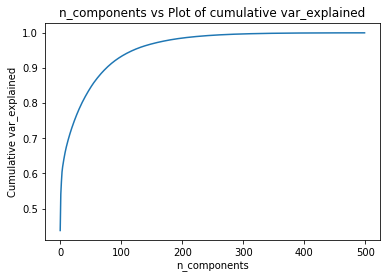

In [0]:
cc = np.cumsum(svd.explained_variance_ratio_)
import matplotlib.pyplot as plt

plt.plot(cc)
plt.xlabel('n_components')
plt.ylabel('Cumulative var_explained')
plt.title('n_components vs Plot of cumulative var_explained')
plt.show()

Will take n_components as 200

In [0]:
svd = TruncatedSVD(n_components=200)
X_svd = svd.fit_transform(X)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, test_size=0.2)

In [0]:
from keras import models
from keras import layers
from keras.layers import Dropout
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
#model.add(Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(layers.Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 256)               51456     
_________________________________________________________________
dense_143 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_144 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_145 (Dense)            (None, 10)                650       
Total params: 93,258
Trainable params: 93,258
Non-trainable params: 0
_________________________________________________________________


In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=50, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(X_train,y_train,epochs=500,batch_size=32,validation_data=(X_test,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 8s 10ms/step - loss: 2.0390 - acc: 0.2938 - val_loss: 1.8079 - val_acc: 0.4050
Epoch 2/500
800/800 [==============================] - 0s 170us/step - loss: 1.2670 - acc: 0.6050 - val_loss: 1.5542 - val_acc: 0.5150
Epoch 3/500
800/800 [==============================] - 0s 157us/step - loss: 0.7892 - acc: 0.7688 - val_loss: 1.3723 - val_acc: 0.5950
Epoch 4/500
800/800 [==============================] - 0s 178us/step - loss: 0.4529 - acc: 0.9075 - val_loss: 1.3662 - val_acc: 0.6300
Epoch 5/500
800/800 [==============================] - 0s 159us/step - loss: 0.2707 - acc: 0.9587 - val_loss: 1.3445 - val_acc: 0.6350
Epoch 6/500
800/800 [==============================] - 0s 167us/step - loss: 0.1561 - acc: 0.9800 - val_loss: 1.4256 - val_acc: 0.6200
Epoch 7/500
800/800 [==============================] - 0s 165us/step - loss: 0.0934 - acc: 0.9913 - val_loss: 1.4837 - val_acc: 0.6050
Epoch 8/50

In [0]:
print(model.evaluate(X_train,y_train,batch_size=64)) 
model.evaluate(X_test,y_test,batch_size=64)

800/800 [==============================] - 0s 40us/step
[0.002641745782457292, 0.99875]
200/200 [==============================] - 0s 52us/step


[2.155197887420654, 0.645]

    This is a decent model too. 
    
    Solution 2 : Using only spectral features and not use the rhythm features

**Using just the sectral features**

In [0]:
#Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(dff.iloc[:,:-385]))

In [0]:
y = dff['label']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train1, y_test1 = train_test_split(X, y, test_size=0.2)

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
aa = enc.fit(np.array(y_train1.values).reshape(-1, 1))
y_train = enc.transform(np.array(y_train1.values).reshape(-1, 1))
y_test = enc.transform(np.array(y_test1.values).reshape(-1, 1))

**Simple NN**

In [0]:
from keras import models
from keras import layers
from keras.layers import Dropout
model = models.Sequential()

model.add(layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

model.add(layers.Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2048)              421888    
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=50, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(X_train,y_train,epochs=500,batch_size=32,validation_data=(X_test,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 1s 1ms/step - loss: 2.3546 - acc: 0.1925 - val_loss: 1.7672 - val_acc: 0.3100
Epoch 2/500
800/800 [==============================] - 0s 357us/step - loss: 2.0662 - acc: 0.3050 - val_loss: 1.5447 - val_acc: 0.5150
Epoch 3/500
800/800 [==============================] - 0s 336us/step - loss: 1.7496 - acc: 0.3725 - val_loss: 1.3588 - val_acc: 0.5350
Epoch 4/500
800/800 [==============================] - 0s 336us/step - loss: 1.6232 - acc: 0.4125 - val_loss: 1.3028 - val_acc: 0.5700
Epoch 5/500
800/800 [==============================] - 0s 317us/step - loss: 1.4277 - acc: 0.4938 - val_loss: 1.2545 - val_acc: 0.6050
Epoch 6/500
800/800 [==============================] - 0s 316us/step - loss: 1.3895 - acc: 0.5038 - val_loss: 1.2302 - val_acc: 0.6000
Epoch 7/500
800/800 [==============================] - 0s 312us/step - loss: 1.2787 - acc: 0.5375 - val_loss: 1.1790 - val_acc: 0.6400
Epoch 8/500

In [0]:
print(model.evaluate(X_train,y_train,batch_size=64)) 
model.evaluate(X_test,y_test,batch_size=64)

800/800 [==============================] - 0s 46us/step
[0.05027260299772024, 0.995]
200/200 [==============================] - 0s 57us/step


[1.2857227039337158, 0.75]

In [0]:
#Plotting The Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y):
  C = confusion_matrix(test_y, predict_y)
  print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
  
  A =(((C.T)/(C.sum(axis=1))).T)
  
  B =(C/C.sum(axis=0))
  
  labels = [0,1,2,3,4,5,6,7,8,9]
  cmap=sns.light_palette("green")
  print("-"*50, "Confusion matrix", "-"*50)
  plt.figure(figsize=(10,5))
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
  print("-"*50, "Precision matrix", "-"*50)
  plt.figure(figsize=(10,5))
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
  print("Sum of columns in precision matrix",B.sum(axis=0))
  
  print("-"*50, "Recall matrix" , "-"*50)
  plt.figure(figsize=(10,5))
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
  print("Sum of rows in precision matrix",A.sum(axis=1))

In [0]:
outy = model.predict(X_test)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)

In [0]:
y_ori = []
for i in list(y_test1):
  if(i == 'blues'):
    y_ori.append(0)
  elif(i == 'classical'):
    y_ori.append(1)
  elif(i == 'country'):
    y_ori.append(2)
  elif(i == 'disco'):
    y_ori.append(3)
  elif(i == 'hiphop'):
    y_ori.append(4)
  elif(i == 'jazz'):
    y_ori.append(5)
  elif(i == 'metal'):
    y_ori.append(6)
  elif(i == 'pop'):
    y_ori.append(7)
  
  elif(i == 'reggae'):
    y_ori.append(8)

  else:
    y_ori.append(9)

In [0]:
enc.get_feature_names()

array(['x0_blues', 'x0_classical', 'x0_country', 'x0_disco', 'x0_hiphop',
       'x0_jazz', 'x0_metal', 'x0_pop', 'x0_reggae', 'x0_rock'],
      dtype=object)

Number of misclassified points  25.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


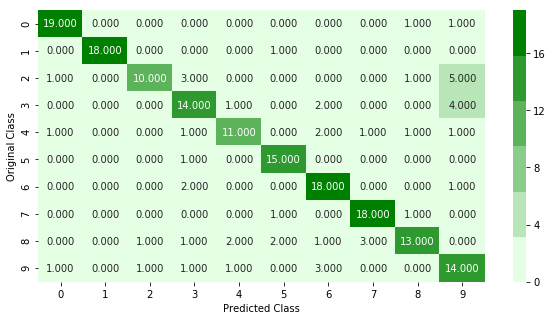

-------------------------------------------------- Precision matrix --------------------------------------------------


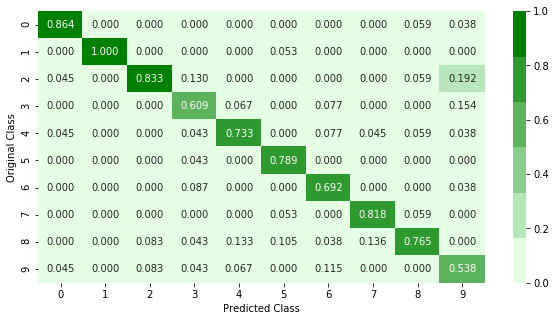

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


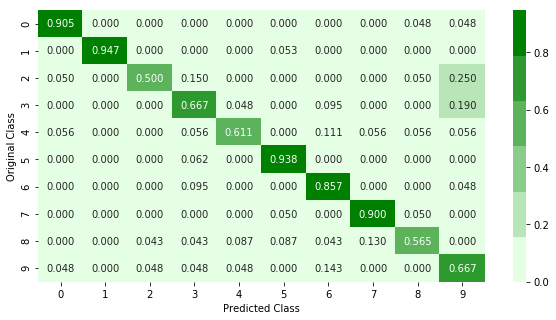

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
plot_confusion_matrix(y_ori, y_pred)

**Parameter Tuning above model**

In [0]:
from keras import models
from keras import layers
from keras.layers import Dropout
model = models.Sequential()

model.add(layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               26368     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 10)                170       
Total params: 37,402
Trainable params: 37,402
Non-trainable params: 0
__________________________________________________

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=50, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(X_train,y_train,epochs=500,batch_size=8,validation_data=(X_test,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 1s 1ms/step - loss: 2.2216 - acc: 0.1762 - val_loss: 1.9096 - val_acc: 0.2700
Epoch 2/500
800/800 [==============================] - 1s 669us/step - loss: 1.7834 - acc: 0.3625 - val_loss: 1.5117 - val_acc: 0.4750
Epoch 3/500
800/800 [==============================] - 1s 683us/step - loss: 1.5381 - acc: 0.4350 - val_loss: 1.3567 - val_acc: 0.4950
Epoch 4/500
800/800 [==============================] - 1s 683us/step - loss: 1.4266 - acc: 0.4775 - val_loss: 1.2585 - val_acc: 0.5450
Epoch 5/500
800/800 [==============================] - 1s 702us/step - loss: 1.2545 - acc: 0.5513 - val_loss: 1.1751 - val_acc: 0.6150
Epoch 6/500
800/800 [==============================] - 1s 703us/step - loss: 1.1727 - acc: 0.5812 - val_loss: 1.1348 - val_acc: 0.6300
Epoch 7/500
800/800 [==============================] - 1s 705us/step - loss: 1.1532 - acc: 0.5925 - val_loss: 1.1300 - val_acc: 0.6250
Epoch 8/500

In [0]:
print(model.evaluate(X_train,y_train,batch_size=64)) 
model.evaluate(X_test,y_test,batch_size=64)

800/800 [==============================] - 0s 39us/step
[0.04243120960891247, 0.99375]
200/200 [==============================] - 0s 54us/step


[1.1718570232391357, 0.78]

In [0]:
outy = model.predict(X_test)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)

Number of misclassified points  22.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


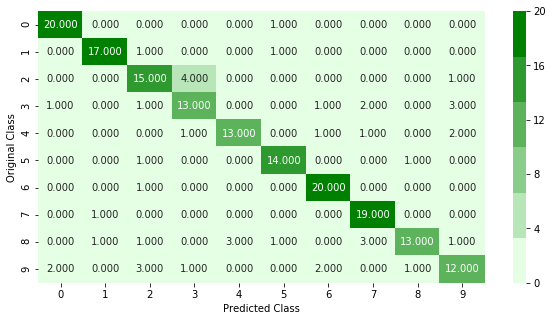

-------------------------------------------------- Precision matrix --------------------------------------------------


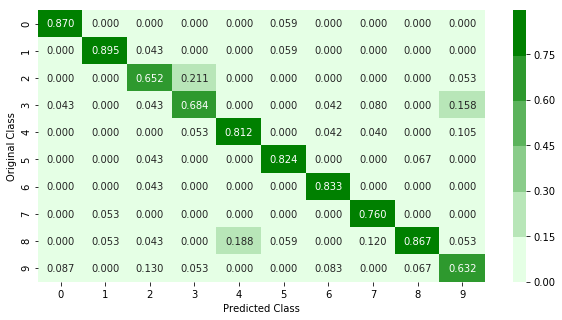

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


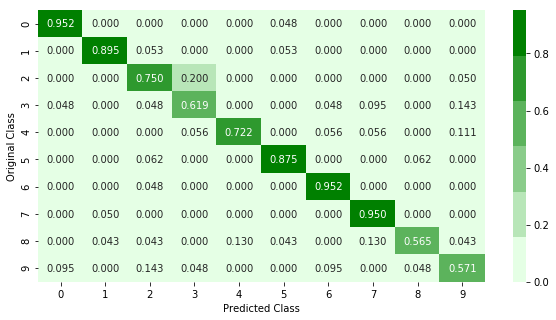

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
plot_confusion_matrix(y_ori, y_pred)

**Using 1-D Convnet**

In [0]:
x_train_conv = np.expand_dims(X_train, axis = -1)
x_test_conv = np.expand_dims(X_test, axis = -1)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D,MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu',input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))
model.add(Dropout(0.35))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Dropout(0.25))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Dropout(0.15))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))


model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))


model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 204, 256)          768       
_________________________________________________________________
dropout_34 (Dropout)         (None, 204, 256)          0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 203, 128)          65664     
_________________________________________________________________
dropout_35 (Dropout)         (None, 203, 128)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 202, 64)           16448     
_________________________________________________________________
dropout_36 (Dropout)         (None, 202, 64)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12928)           

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=50, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train_conv,y_train,epochs=500,batch_size=8,validation_data=(x_test_conv,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 4s 6ms/step - loss: 2.0293 - acc: 0.2712 - val_loss: 1.4962 - val_acc: 0.4700
Epoch 2/500
800/800 [==============================] - 1s 2ms/step - loss: 1.4402 - acc: 0.4850 - val_loss: 1.2502 - val_acc: 0.5700
Epoch 3/500
800/800 [==============================] - 1s 2ms/step - loss: 1.1895 - acc: 0.6000 - val_loss: 1.0957 - val_acc: 0.6400
Epoch 4/500
800/800 [==============================] - 1s 2ms/step - loss: 0.9818 - acc: 0.6875 - val_loss: 0.9952 - val_acc: 0.6450
Epoch 5/500
800/800 [==============================] - 1s 2ms/step - loss: 0.8071 - acc: 0.7262 - val_loss: 1.0121 - val_acc: 0.7000
Epoch 6/500
800/800 [==============================] - 1s 2ms/step - loss: 0.6469 - acc: 0.7938 - val_loss: 1.0672 - val_acc: 0.6750
Epoch 7/500
800/800 [==============================] - 1s 2ms/step - loss: 0.5016 - acc: 0.8413 - val_loss: 1.2244 - val_acc: 0.6800
Epoch 8/500
800/800 [==

In [0]:
print(model.evaluate(x_train_conv,y_train,batch_size=64)) 
model.evaluate(x_test_conv,y_test,batch_size=64)

800/800 [==============================] - 0s 145us/step
[0.022256753291003406, 0.99875]
200/200 [==============================] - 0s 132us/step


[1.4518716764450073, 0.76]

In [0]:
outy = model.predict(x_test_conv)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)

Number of misclassified points  24.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


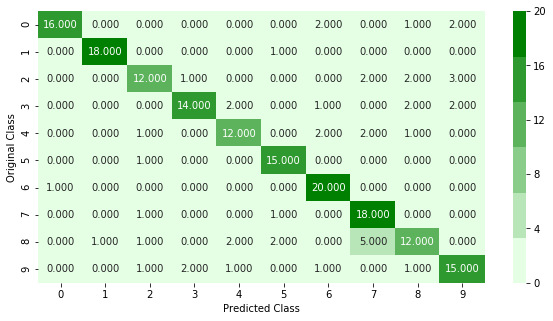

-------------------------------------------------- Precision matrix --------------------------------------------------


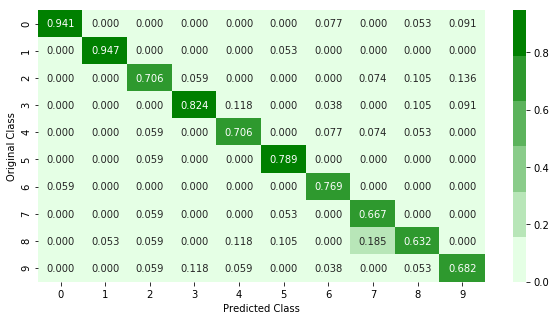

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


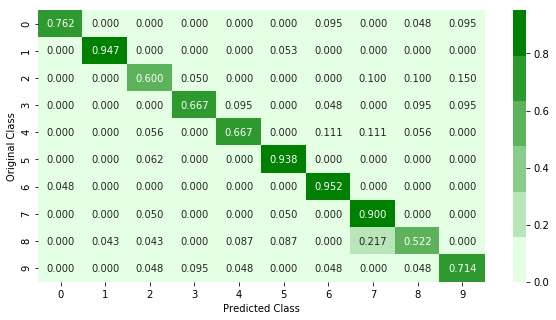

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
plot_confusion_matrix(y_ori, y_pred)

**Using LSTM**

In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

model = Sequential()

model.add(LSTM(units=2048, dropout=0.5, recurrent_dropout=0.35, return_sequences=True, input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))


model.add(LSTM(units=1024,  dropout=0.5, recurrent_dropout=0.35, return_sequences=True))


model.add(LSTM(units=512,  dropout=0.25, recurrent_dropout=0.35, return_sequences=True))


model.add(LSTM(units=256,  dropout=0.25, recurrent_dropout=0.35, return_sequences=True))

model.add(Flatten())


model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 205, 2048)         16793600  
_________________________________________________________________
lstm_40 (LSTM)               (None, 205, 1024)         12587008  
_________________________________________________________________
lstm_41 (LSTM)               (None, 205, 512)          3147776   
_________________________________________________________________
lstm_42 (LSTM)               (None, 205, 256)          787456    
_________________________________________________________________
flatten_18 (Flatten)         (None, 52480)             0         
_________________________________________________________________
dense_58 (Dense)             (None, 10)                524810    
Total params: 33,840,650
Trainable params: 33,840,650
Non-trainable params: 0
_________________________________________

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=30, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train_conv,y_train,epochs=300,batch_size=64,validation_data=(x_test_conv,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/300
800/800 [==============================] - 85s 106ms/step - loss: 2.2074 - acc: 0.1837 - val_loss: 1.9119 - val_acc: 0.3600
Epoch 2/300
800/800 [==============================] - 68s 85ms/step - loss: 2.0074 - acc: 0.2650 - val_loss: 1.4791 - val_acc: 0.4850
Epoch 3/300
800/800 [==============================] - 69s 86ms/step - loss: 1.9292 - acc: 0.2975 - val_loss: 1.4465 - val_acc: 0.4550
Epoch 4/300
800/800 [==============================] - 69s 86ms/step - loss: 1.9389 - acc: 0.3050 - val_loss: 1.4835 - val_acc: 0.4700
Epoch 5/300
800/800 [==============================] - 68s 86ms/step - loss: 1.9966 - acc: 0.3038 - val_loss: 1.4271 - val_acc: 0.5050
Epoch 6/300
800/800 [==============================] - 68s 85ms/step - loss: 1.8345 - acc: 0.3225 - val_loss: 1.5537 - val_acc: 0.5000
Epoch 7/300
800/800 [==============================] - 69s 86ms/step - loss: 1.7829 - acc: 0.3475 - val_loss: 1.3694 - val_acc: 0.5600
Epoch 8/

In [0]:
print(model.evaluate(x_train_conv,y_train,batch_size=64)) 
model.evaluate(x_test_conv,y_test,batch_size=64)

800/800 [==============================] - 17s 22ms/step
[0.5854130077362061, 0.8075]
200/200 [==============================] - 5s 25ms/step


[1.047603783607483, 0.68]

In [0]:
outy = model.predict(x_test_conv)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)

Number of misclassified points  32.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


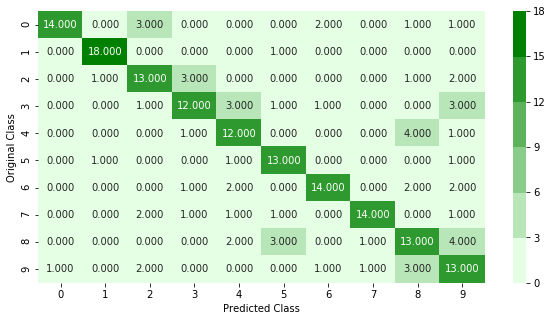

-------------------------------------------------- Precision matrix --------------------------------------------------


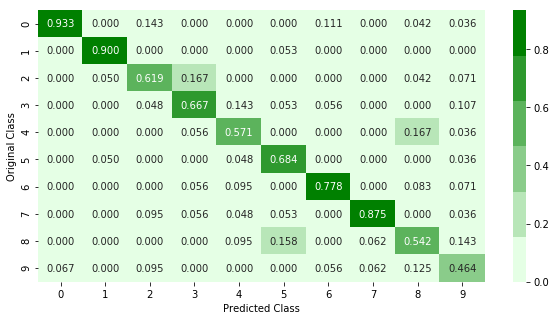

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


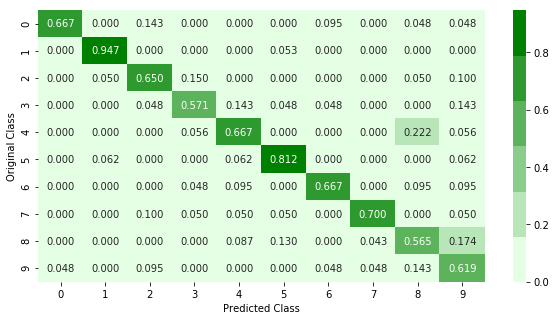

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
plot_confusion_matrix(y_ori, y_pred)

**Using Bi-Directional LSTM**

In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional


model = Sequential()

model.add(LSTM(units=1024, dropout=0.5, recurrent_dropout=0.35, return_sequences=True, input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))


model.add(Bidirectional(LSTM(units=512,  dropout=0.5, recurrent_dropout=0.35, return_sequences=True)))


model.add(Bidirectional(LSTM(units=256,  dropout=0.5, recurrent_dropout=0.35, return_sequences=True)))

model.add(Flatten())

model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 205, 1024)         4202496   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 205, 1024)         6295552   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 205, 512)          2623488   
_________________________________________________________________
flatten_20 (Flatten)         (None, 104960)            0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)                1049610   
Total params: 14,171,146
Trainable params: 14,171,146
Non-trainable params: 0
_________________________________________________________________


In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=30, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(x_train_conv,y_train,epochs=300,batch_size=64,validation_data=(x_test_conv,y_test),callbacks=[es],verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/300
800/800 [==============================] - 62s 78ms/step - loss: 2.2317 - acc: 0.1775 - val_loss: 1.8158 - val_acc: 0.3550
Epoch 2/300
800/800 [==============================] - 46s 57ms/step - loss: 2.1066 - acc: 0.2337 - val_loss: 1.7455 - val_acc: 0.4350
Epoch 3/300
800/800 [==============================] - 46s 58ms/step - loss: 2.0246 - acc: 0.2487 - val_loss: 1.5881 - val_acc: 0.4300
Epoch 4/300
800/800 [==============================] - 46s 57ms/step - loss: 1.8909 - acc: 0.3025 - val_loss: 1.3689 - val_acc: 0.5350
Epoch 5/300
800/800 [==============================] - 46s 57ms/step - loss: 1.8853 - acc: 0.3350 - val_loss: 1.4067 - val_acc: 0.5200
Epoch 6/300
800/800 [==============================] - 46s 57ms/step - loss: 1.8078 - acc: 0.3250 - val_loss: 1.4289 - val_acc: 0.5450
Epoch 7/300
800/800 [==============================] - 45s 57ms/step - loss: 1.8158 - acc: 0.3400 - val_loss: 1.3115 - val_acc: 0.5600
Epoch 8/3

In [0]:
print(model.evaluate(x_train_conv,y_train,batch_size=64)) 
model.evaluate(x_test_conv,y_test,batch_size=64)

800/800 [==============================] - 14s 17ms/step
[0.4969660997390747, 0.83875]
200/200 [==============================] - 4s 20ms/step


[1.1595258235931396, 0.665]

In [0]:
outy = model.predict(x_test_conv)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)

Number of misclassified points  33.5
-------------------------------------------------- Confusion matrix --------------------------------------------------


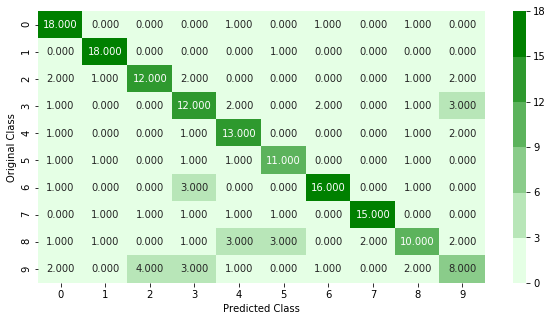

-------------------------------------------------- Precision matrix --------------------------------------------------


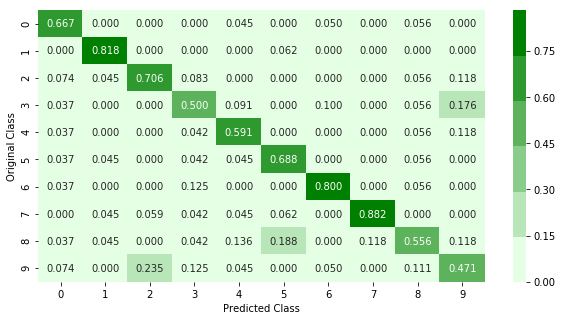

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


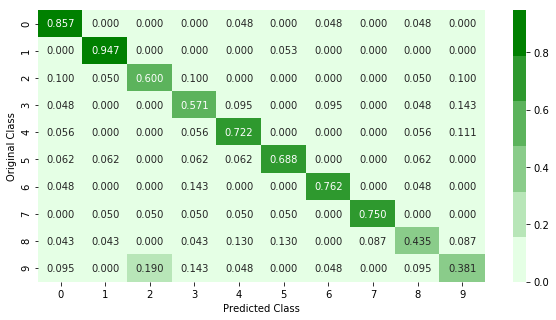

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
plot_confusion_matrix(y_ori, y_pred)

**Using the librosa Features from full FMA Dataset**

- > I will use the FMA Full Dataset for this. For this problem, I will use only the extracted features not the audio files cos it's around 900+GB and since I have space constrains I couldn't download the whole dataset also finding the librosa features for all these files will take alot of time. So I will use already computed features. This file is available in https://github.com/mdeff/fma.

    The feautres they have considered are : 
    
        mfcc
    
        chroma_cens
    
        tonnetz
    
        spectral_contrast
        
        spectral_centroid
        
        spectral_bandwidth
        
        spectral_rolloff
        
        rmse
        
        zcr

In [0]:
import os
import urllib.request

import sys
import time
import urllib
# Using Progress bar : https://blog.shichao.io/2012/10/04/progress_speed_indicator_for_urlretrieve_in_python.html

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
                    (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()



urllib.request.urlretrieve('https://os.unil.cloud.switch.ch/fma/fma_metadata.zip', 'fma_metadata.zip',reporthook)

...100%, 341 MB, 7530 KB/s, 46 seconds passed

('fma_metadata.zip', <http.client.HTTPMessage at 0x7f0ff09d7dd8>)

In [0]:
!unzip fma_metadata.zip

Archive:  fma_metadata.zip
 bunzipping: fma_metadata/README.txt  
 bunzipping: fma_metadata/checksums  
 bunzipping: fma_metadata/not_found.pickle  
 bunzipping: fma_metadata/raw_genres.csv  
 bunzipping: fma_metadata/raw_albums.csv  
 bunzipping: fma_metadata/raw_artists.csv  
 bunzipping: fma_metadata/raw_tracks.csv  
 bunzipping: fma_metadata/tracks.csv  
 bunzipping: fma_metadata/genres.csv  
 bunzipping: fma_metadata/raw_echonest.csv  
 bunzipping: fma_metadata/echonest.csv  
 bunzipping: fma_metadata/features.csv  


In [0]:
dff = pd.read_csv('fma_metadata/features.csv')
dff.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,2

,feature,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,chroma_cens.10,chroma_cens.11,chroma_cens.12,chroma_cens.13,chroma_cens.14,chroma_cens.15,chroma_cens.16,chroma_cens.17,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.21,chroma_cens.22,chroma_cens.23,chroma_cens.24,chroma_cens.25,chroma_cens.26,chroma_cens.27,chroma_cens.28,chroma_cens.29,chroma_cens.30,chroma_cens.31,chroma_cens.32,chroma_cens.33,chroma_cens.34,chroma_cens.35,chroma_cens.36,chroma_cens.37,chroma_cens.38,...,tonnetz.9,tonnetz.10,tonnetz.11,tonnetz.12,tonnetz.13,tonnetz.14,tonnetz.15,tonnetz.16,tonnetz.17,tonnetz.18,tonnetz.19,tonnetz.20,tonnetz.21,tonnetz.22,tonnetz.23,tonnetz.24,tonnetz.25,tonnetz.26,tonnetz.27,tonnetz.28,tonnetz.29,tonnetz.30,tonnetz.31,tonnetz.32,tonnetz.33,tonnetz.34,tonnetz.35,tonnetz.36,tonnetz.37,tonnetz.38,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
0,statistics,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,max,max,max,max,max,max,max,max,max,max,max,max,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,median,median,median,...,max,max,max,mean,mean,mean,mean,mean,mean,median,median,median,median,median,median,min,min,min,min,min,min,skew,skew,skew,skew,skew,skew,std,std,std,std,std,std,kurtosis,max,mean,median,min,skew,std
1,number,01,02,03,04,05,06,07,08,09,10,11,12,01,02,03,04,05,06,07,08,09,10,11,12,01,02,03,04,05,06,07,08,09,10,11,12,01,02,03,...,04,05,06,01,02,03,04,05,06,01,02,03,04,05,06,01,02,03,04,05,06,01,02,03,04,05,06,01,02,03,04,05,06,01,01,01,01,01,01,01
2,track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,7.1806526184e+00,5.2303090096e+00,2.4932080507e-01,1.3476201296e+00,1.4824777842e+00,5.3137123585e-01,1.4815930128e+00,2.6914546490e+00,8.6686819792e-01,1.3412306309e+00,1.3477915525e+00,1.2376583815e+00,6.9249993563e-01,5.6934404373e-01,5.9704089165e-01,6.2586373091e-01,5.6732958555e-01,4.4394925237e-01,4.8797628284e-01,4.9732723832e-01,5.7443547249e-01,5.7924067974e-01,6.2010246515e-01,5.8694541454e-01,4.7430026531e-01,3.6981594563e-01,2.3611885309e-01,2.2806788981e-01,2.2282999754e-01,2.2141483426e-01,2.2923804820e-01,2.4879531562e-01,1.9624517858e-01,1.7580920458e-01,2.0071266592e-01,3.1997194886e-01,4.8282524943e-01,3.8765248656e-01,2.4908207357e-01,...,3.1897184253e-01,5.9689950198e-02,6.9183945656e-02,-2.5701194536e-03,1.9296063110e-02,1.0509796441e-02,7.3464401066e-02,9.2724012211e-03,1.5764819458e-02,-3.7893503904e-03,1.7786035314e-02,7.3111997917e-03,6.7944541574e-02,9.4880592078e-03,1.6876112670e-02,-5.9769075364e-02,-9.1745235026e-02,-1.8568652868e-01,-1.4030629396e-01,-4.8524703830e-02,-8.9285716414e-02,7.5246191025e-01,2.6260730624e-01,2.0094415545e-01,5.9359472990e-01,-1.7766456306e-01,-1.4242012501e+00,1.9809417427e-02,2.9568683356e-02,3.8974210620e-02,5.4125156254e-02,1.2225749902e-02,1.2110591866e-02,5.7588901520e+00,4.5947265625e-01,8.5629448295e-02,7.1289062500e-02,0.0000000000e+00,2.0898721218e+00,6.1448108405e-02
4,3,1.8889633417e+00,7.6053929329e-01,3.4529656172e-01,2.2952005863e+00,1.6540306807e+00,6.7592434585e-02,1.3668476343e+00,1.0540937185e+00,1.0810308903e-01,6.1918509007e-01,1.0382531881e+00,1.2922351360e+00,6.7764127254e-01,5.8424842358e-01,5.8127075434e-01,5.8118158579e-01,4.5424115658e-01,4.6484073997e-01,5.4283261299e-01,6.6471982002e-01,5.1132947206e-01,5.3099834919e-01,6.0339796543e-01,5.4742807150e-01,2.3278446496e-01,2.2946873307e-01,2.2567413747e-01,2.1671250463e-01,2.2051233053e-01,2.4274352193e-01,3.6923468113e-01,4.2071598768e-01,3.1212857366e-01,2.4274821579e-01,2.6429188251e-01,2.2568309307e-01,

In [0]:
dff.drop([0,1,2],inplace=True)

In [0]:
dff.rename(columns={"feature": "track_id"},inplace=True)

In [0]:
dff.head()

,track_id,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,chroma_cens.10,chroma_cens.11,chroma_cens.12,chroma_cens.13,chroma_cens.14,chroma_cens.15,chroma_cens.16,chroma_cens.17,chroma_cens.18,chroma_cens.19,chroma_cens.20,chroma_cens.21,chroma_cens.22,chroma_cens.23,chroma_cens.24,chroma_cens.25,chroma_cens.26,chroma_cens.27,chroma_cens.28,chroma_cens.29,chroma_cens.30,chroma_cens.31,chroma_cens.32,chroma_cens.33,chroma_cens.34,chroma_cens.35,chroma_cens.36,chroma_cens.37,chroma_cens.38,...,tonnetz.9,tonnetz.10,tonnetz.11,tonnetz.12,tonnetz.13,tonnetz.14,tonnetz.15,tonnetz.16,tonnetz.17,tonnetz.18,tonnetz.19,tonnetz.20,tonnetz.21,tonnetz.22,tonnetz.23,tonnetz.24,tonnetz.25,tonnetz.26,tonnetz.27,tonnetz.28,tonnetz.29,tonnetz.30,tonnetz.31,tonnetz.32,tonnetz.33,tonnetz.34,tonnetz.35,tonnetz.36,tonnetz.37,tonnetz.38,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
3,2,7.1806526184e+00,5.2303090096e+00,2.4932080507e-01,1.3476201296e+00,1.4824777842e+00,5.3137123585e-01,1.4815930128e+00,2.6914546490e+00,8.6686819792e-01,1.3412306309e+00,1.3477915525e+00,1.2376583815e+00,6.9249993563e-01,5.6934404373e-01,5.9704089165e-01,6.2586373091e-01,5.6732958555e-01,4.4394925237e-01,4.8797628284e-01,4.9732723832e-01,5.7443547249e-01,5.7924067974e-01,6.2010246515e-01,5.8694541454e-01,4.7430026531e-01,3.6981594563e-01,2.3611885309e-01,2.2806788981e-01,2.2282999754e-01,2.2141483426e-01,2.2923804820e-01,2.4879531562e-01,1.9624517858e-01,1.7580920458e-01,2.0071266592e-01,3.1997194886e-01,4.8282524943e-01,3.8765248656e-01,2.4908207357e-01,...,3.1897184253e-01,5.9689950198e-02,6.9183945656e-02,-2.5701194536e-03,1.9296063110e-02,1.0509796441e-02,7.3464401066e-02,9.2724012211e-03,1.5764819458e-02,-3.7893503904e-03,1.7786035314e-02,7.3111997917e-03,6.7944541574e-02,9.4880592078e-03,1.6876112670e-02,-5.9769075364e-02,-9.1745235026e-02,-1.8568652868e-01,-1.4030629396e-01,-4.8524703830e-02,-8.9285716414e-02,7.5246191025e-01,2.6260730624e-01,2.0094415545e-01,5.9359472990e-01,-1.7766456306e-01,-1.4242012501e+00,1.9809417427e-02,2.9568683356e-02,3.8974210620e-02,5.4125156254e-02,1.2225749902e-02,1.2110591866e-02,5.7588901520e+00,4.5947265625e-01,8.5629448295e-02,7.1289062500e-02,0.0000000000e+00,2.0898721218e+00,6.1448108405e-02
4,3,1.8889633417e+00,7.6053929329e-01,3.4529656172e-01,2.2952005863e+00,1.6540306807e+00,6.7592434585e-02,1.3668476343e+00,1.0540937185e+00,1.0810308903e-01,6.1918509007e-01,1.0382531881e+00,1.2922351360e+00,6.7764127254e-01,5.8424842358e-01,5.8127075434e-01,5.8118158579e-01,4.5424115658e-01,4.6484073997e-01,5.4283261299e-01,6.6471982002e-01,5.1132947206e-01,5.3099834919e-01,6.0339796543e-01,5.4742807150e-01,2.3278446496e-01,2.2946873307e-01,2.2567413747e-01,2.1671250463e-01,2.2051233053e-01,2.4274352193e-01,3.6923468113e-01,4.2071598768e-01,3.1212857366e-01,2.4274821579e-01,2.6429188251e-01,2.2568309307e-01,2.3057937622e-01,2.2805927694e-01,2.0937032998e-01,...,2.1480709314e-01,7.0261307061e-02,7.0394344628e-02,1.8286141858e-04,6.9077485241e-03,4.7025315464e-02,-2.9941925779e-02,1.7534568906e-02,-1.4961191919e-03,-1.0820356692e-04,7.1613714099e-03,4.6912353486e-02,-2.1148968488e-02,1.6299011186e-02,-2.6571142953e-03,-9.7198762000e-02,-7.9650551081e-02,-1.6461294889e-01,-3.0437546968e-01,-2.4957695976e-02,-5.5667165667e-02,2.6554071903e-01,-1.3147148490e-01,1.7193038762e-01,-9.9070966244e-01,5.7455557585e-01,5.5649441481e-01,2.6315923780e-02,1.8707795069e-02,5.1150608808e-02,6.3831120729e-02,1.4211839065e-02,1.7740072682e-02,2.8246941566e+00,4.6630859375e-01,8.4578499198e-02,6.3964843750e-02,0.0000000000e+00,1.7167237997e+00,6.9330163300e-02
5,5,5.2756297588e-01,-7.7654317021e-02,-2.7961030602e-01,6.8588310480e-01,1.9375696182e+00,8.8083887100e-01,-9.2319184542e-01,-9.2723226547e-01,6.6661673784e-01,1.0385463238e+00,2.6893171668e-01,1.1251406670e+00,6.1101400852e-01,6.5147054195e-01,4.9452754855e-01,4.4879883528e-01,4.6862

In [0]:
tracks = pd.read_csv('fma_metadata/tracks.csv')
tracks.drop([0,1],inplace=True)
tracks.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,album,album.1,album.2,album.3,album.4,album.5,album.6,album.7,album.8,album.9,album.10,album.11,album.12,artist,artist.1,artist.2,artist.3,artist.4,artist.5,artist.6,artist.7,artist.8,artist.9,artist.10,artist.11,artist.12,artist.13,artist.14,artist.15,artist.16,set,set.1,track,track.1,track.2,track.3,track.4,track.5,track.6,track.7,track.8,track.9,track.10,track.11,track.12,track.13,track.14,track.15,track.16,track.17,track.18,track.19
2,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
4,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.0583238,New Jersey,-74.4056612,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
5,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
6,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


In [0]:
dff['genre_top'] = tracks['track.7']
dff['all_feat'] = tracks['track.9']

In [0]:
dff['genre_top'].value_counts()

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3551
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: genre_top, dtype: int64

**SINCE THERE IS A HIGHLY IMBALANCED DATASET, I'LL USE ONLY THE TOP 10 CLASSES NAMELY**

- > Rock

- > Experimental           

- > Electronic              

- > Hip-Hop                 

- > Folk                    

- > Pop                     

- > Instrumental            

- > International           

- > Classical

- > Jazz

In [0]:
df_genre = dff

In [0]:
aa = df_genre[((df_genre['genre_top']!='Easy Listening') & (df_genre['genre_top']!='Blues') & (df_genre['genre_top']!='Spoken')
              & (df_genre['genre_top']!='Soul-RnB') & (df_genre['genre_top']!='Country') & (df_genre['genre_top']!='Old-Time / Historic'))]

In [0]:
aa['genre_top'].value_counts()

Rock             14182
Experimental     10608
Electronic        9372
Hip-Hop           3551
Folk              2803
Pop               2332
Instrumental      2079
International     1389
Classical         1230
Jazz               571
Name: genre_top, dtype: int64

In [0]:
aa.shape

(105094, 521)

In [0]:
dff = aa.dropna(axis=0,subset=['genre_top'])
dff.to_csv('fma_full_feat.csv',index=False)

In [0]:
dff = pd.read_csv('fma_full_feat.csv')

In [0]:
dff.drop('track_id',axis=1,inplace=True)

In [5]:
#Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(dff.iloc[:,:-2]))
X.shape

(48117, 518)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train1, y_test1 = train_test_split(X, dff['genre_top'], test_size=0.2)

In [7]:
# Number Of Labels In train
y_train1.value_counts()

Rock             11327
Experimental      8556
Electronic        7476
Hip-Hop           2877
Folk              2235
Pop               1864
Instrumental      1654
International     1086
Classical          971
Jazz               447
Name: genre_top, dtype: int64

In [8]:
#Number of labels for Test
y_test1.value_counts()

Rock             2855
Experimental     2052
Electronic       1896
Hip-Hop           674
Folk              568
Pop               468
Instrumental      425
International     303
Classical         259
Jazz              124
Name: genre_top, dtype: int64

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
aa = enc.fit(np.array(y_train1.values).reshape(-1, 1))
y_train = enc.transform(np.array(y_train1.values).reshape(-1, 1))
y_test = enc.transform(np.array(y_test1.values).reshape(-1, 1))

In [0]:
y_ori = []
for i in list(y_test1):
  if(i == 'Classical'):
    y_ori.append(0)
  elif(i == 'Electronic'):
    y_ori.append(1)
  elif(i == 'Experimental'):
    y_ori.append(2)
  elif(i == 'Folk'):
    y_ori.append(3)
  elif(i == 'Hip-Hop'):
    y_ori.append(4)
  elif(i == 'Instrumental'):
    y_ori.append(5)
  elif(i == 'International'):
    y_ori.append(6)
  elif(i == 'Jazz'):
    y_ori.append(7)
  
  elif(i == 'Pop'):
    y_ori.append(8)

  else:
    y_ori.append(9)

In [11]:
enc.get_feature_names()

array(['x0_Classical', 'x0_Electronic', 'x0_Experimental', 'x0_Folk',
       'x0_Hip-Hop', 'x0_Instrumental', 'x0_International', 'x0_Jazz',
       'x0_Pop', 'x0_Rock'], dtype=object)

In [0]:
from keras import models
from keras import layers
from keras.layers import Dropout
model = models.Sequential()

model.add(layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))


model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2048)              1062912   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)              

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=40, mode='max', baseline=None, restore_best_weights=True)

In [0]:
history = model.fit(X_train,y_train,epochs=400,batch_size=128,validation_data=(X_test,y_test),callbacks=[es],verbose=1)

Train on 38493 samples, validate on 9624 samples
Epoch 1/400
38493/38493 [==============================] - 4s 111us/step - loss: 1.7461 - acc: 0.4216 - val_loss: 1.5089 - val_acc: 0.5563
Epoch 2/400
38493/38493 [==============================] - 3s 87us/step - loss: 1.5464 - acc: 0.5089 - val_loss: 1.4423 - val_acc: 0.5735
Epoch 3/400
38493/38493 [==============================] - 3s 86us/step - loss: 1.4809 - acc: 0.5365 - val_loss: 1.4047 - val_acc: 0.5766
Epoch 4/400
38493/38493 [==============================] - 3s 86us/step - loss: 1.4436 - acc: 0.5491 - val_loss: 1.3582 - val_acc: 0.5924
Epoch 5/400
38493/38493 [==============================] - 3s 86us/step - loss: 1.4133 - acc: 0.5621 - val_loss: 1.3626 - val_acc: 0.5908
Epoch 6/400
38493/38493 [==============================] - 3s 86us/step - loss: 1.3892 - acc: 0.5681 - val_loss: 1.3616 - val_acc: 0.5897
Epoch 7/400
38493/38493 [==============================] - 3s 86us/step - loss: 1.3739 - acc: 0.5744 - val_loss: 1.3328 - 

In [0]:
print(model.evaluate(X_train,y_train,batch_size=64)) 
model.evaluate(X_test,y_test,batch_size=64)

38493/38493 [==============================] - 2s 40us/step
[0.8973010927295504, 0.7188839529048278]
9624/9624 [==============================] - 0s 39us/step


[1.2601511415004334, 0.6199085618789654]

In [0]:
outy = model.predict(X_test)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)

Number of misclassified points  38.009143807148796
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


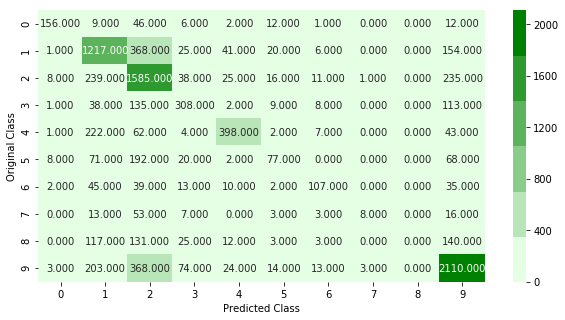

-------------------------------------------------- Precision matrix --------------------------------------------------


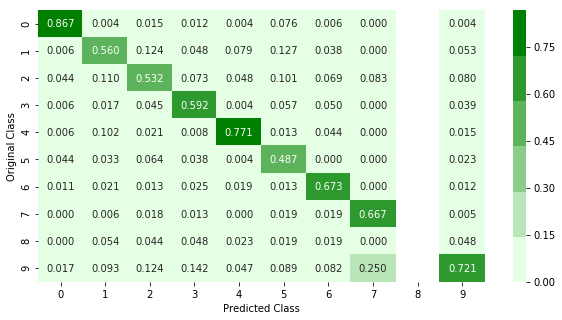

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


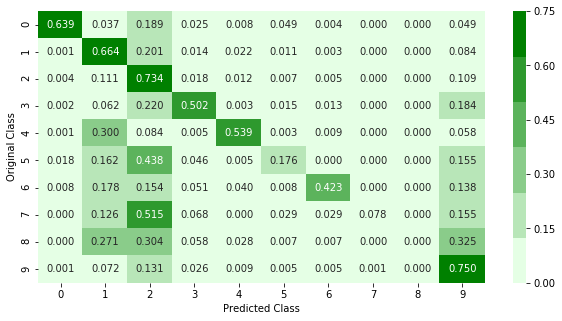

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
plot_confusion_matrix(y_ori, y_pred)

**Using 1D Convnet**

In [0]:
x_train_conv = np.expand_dims(X_train, axis = -1)
x_test_conv = np.expand_dims(X_test, axis = -1)

In [35]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D,MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=1024, kernel_size=1, activation='relu',input_shape=(x_train_conv.shape[1],x_train_conv.shape[2])))

model.add(Conv1D(filters=512, kernel_size=1, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))


model.add(Dense(16, activation='relu'))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 518, 1024)         2048      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 518, 512)          524800    
_________________________________________________________________
flatten_6 (Flatten)          (None, 265216)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                8486944   
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                170       
Total params: 9,014,490
Trainable params: 9,014,490
Non-trainable params: 0
____________________________________________

In [0]:
import keras
model.compile(optimizer='Adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', patience=10, mode='max', baseline=None, restore_best_weights=True)

In [37]:
history = model.fit(x_train_conv,y_train,epochs=100,batch_size=32,validation_data=(x_test_conv,y_test),callbacks=[es],verbose=1)

Train on 38493 samples, validate on 9624 samples
Epoch 1/100
38493/38493 [==============================] - 84s 2ms/step - loss: 1.4441 - acc: 0.5353 - val_loss: 1.3311 - val_acc: 0.5781
Epoch 2/100
38493/38493 [==============================] - 83s 2ms/step - loss: 1.2826 - acc: 0.5935 - val_loss: 1.3023 - val_acc: 0.5879
Epoch 3/100
38493/38493 [==============================] - 83s 2ms/step - loss: 1.2287 - acc: 0.6119 - val_loss: 1.2985 - val_acc: 0.5917
Epoch 4/100
38493/38493 [==============================] - 83s 2ms/step - loss: 1.1924 - acc: 0.6240 - val_loss: 1.2773 - val_acc: 0.5986
Epoch 5/100
38493/38493 [==============================] - 83s 2ms/step - loss: 1.1618 - acc: 0.6341 - val_loss: 1.2802 - val_acc: 0.5969
Epoch 6/100
38493/38493 [==============================] - 83s 2ms/step - loss: 1.1340 - acc: 0.6404 - val_loss: 1.3081 - val_acc: 0.5939
Epoch 7/100
38493/38493 [==============================] - 83s 2ms/step - loss: 1.1093 - acc: 0.6492 - val_loss: 1.3051 - v

In [38]:
print(model.evaluate(x_train_conv,y_train,batch_size=64)) 
model.evaluate(x_test_conv,y_test,batch_size=64)

38493/38493 [==============================] - 22s 567us/step
[1.14241749503014, 0.6382718935840744]
9624/9624 [==============================] - 5s 565us/step


[1.2772819193224063, 0.5986076475477972]

Number of misclassified points  40.139235245220284
-------------------------------------------------- Confusion matrix --------------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


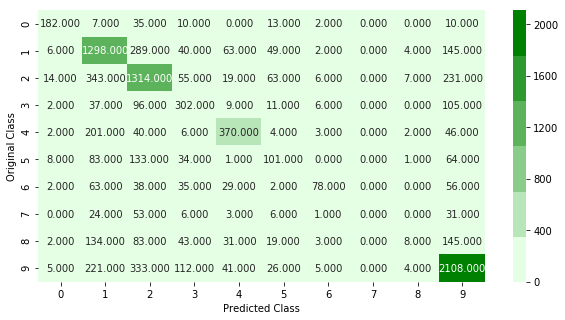

-------------------------------------------------- Precision matrix --------------------------------------------------


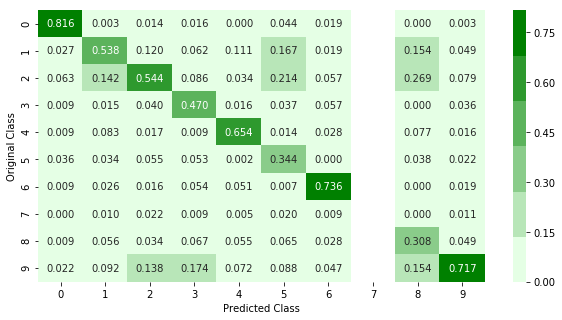

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1. nan  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


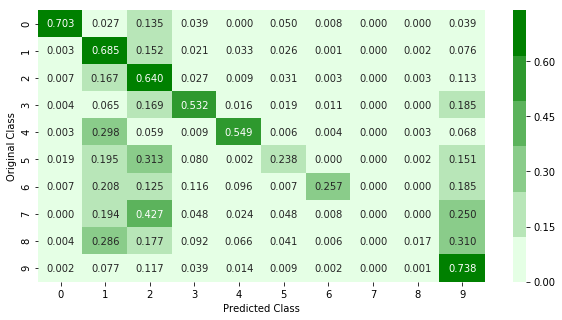

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
outy = model.predict(x_test_conv)
y_pred = []
for i in range(0,len(outy)):
    out = list(outy[i]).index(max(list(outy[i])))
    y_pred.append(out)
    
plot_confusion_matrix(y_ori, y_pred)

### Conclusion :

    For the GTZAN Dataset, Which is balanced dataset, I was able to get a test accuracy of 78% which is more than that FMA medium and FMA whole dataset
    
    However Using further Hyperparameter tuning, the accuracy of the models can be improved.